In [1]:
from utils import *

In [2]:
logperm, perm, poro, timesteps, bhp, pressure, saturation, well_locs, well_locs_mask = load_data()

Log-Perm: (32, 32)
Permeability: (32, 32, 3) | Porosity: (32, 32)
Pressure: (100, 32, 32, 60) | Saturation: (100, 32, 32, 60)
Timesteps: (60, 1) | BHP: (100, 60)
Well Locations: (100, 2) | Well Locations MASK: (100, 32, 32)


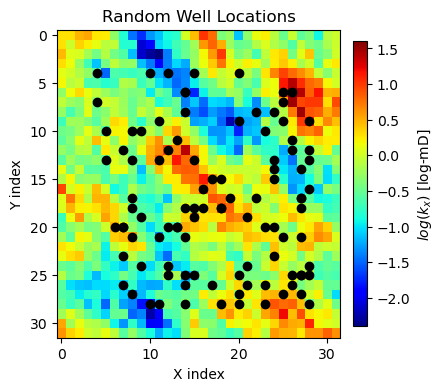

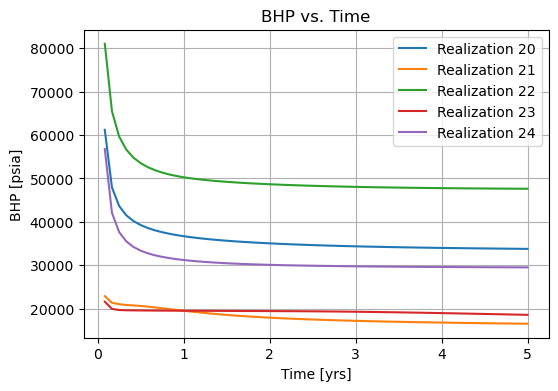

In [3]:
plot_well_locs(well_locs, logperm)
plot_bhps(bhp, timesteps, range(20,25))

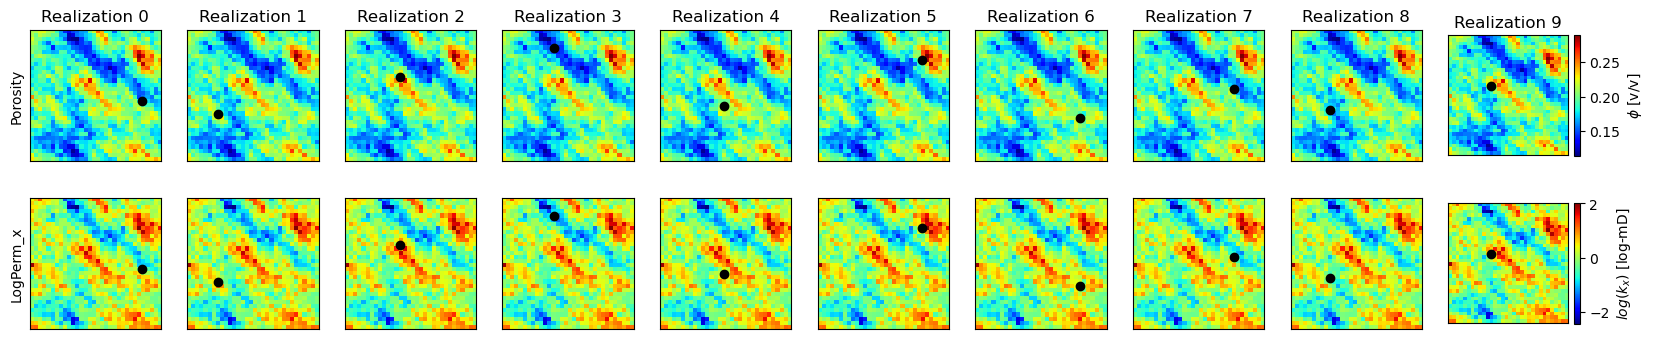

In [8]:
plot_static(poro, perm, well_locs, 10, figsize=(20,4))

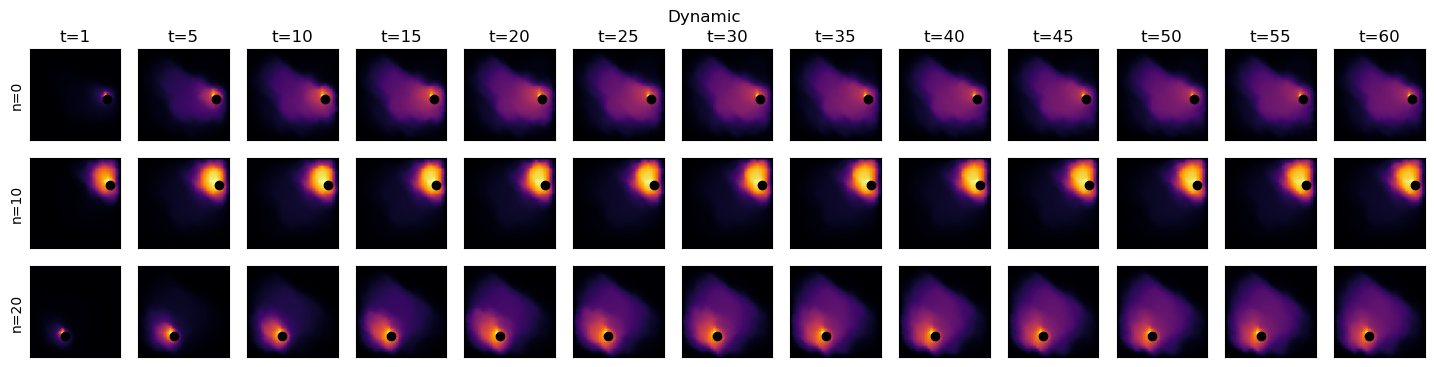

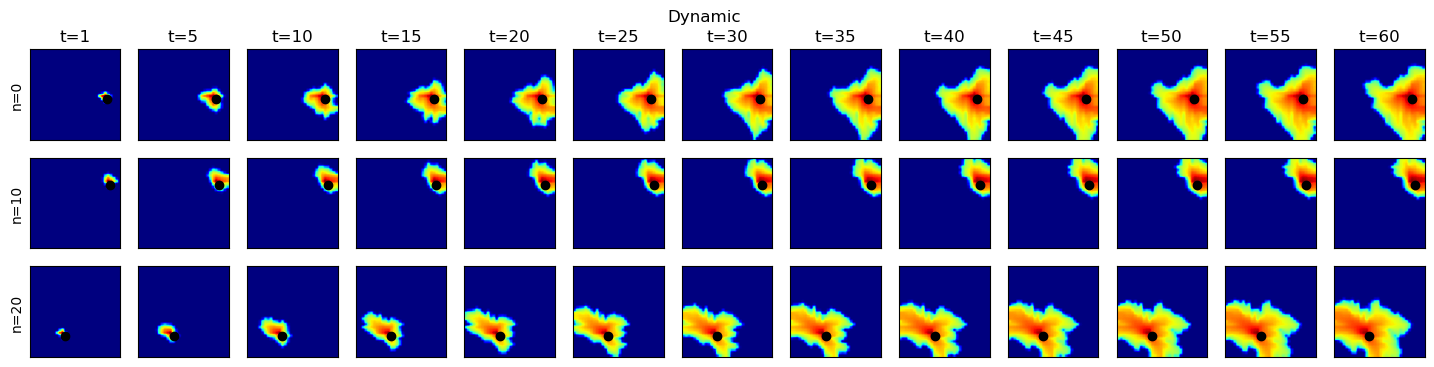

In [5]:
plot_dynamic(pressure, well_locs, 3, multiplier=10, cmap='inferno')
plot_dynamic(saturation, well_locs, 3, multiplier=10, cmap='jet')

***
# END